In [8]:
import pandas as pd

# Set display options to show full text in each cell
pd.set_option('display.max_colwidth', None)
# Read the CSV file
data = pd.read_csv('/kaggle/input/train-csv/train.csv')

# Display top 20 rows
print("Top 20 rows:")
print(data.head(20))

# Extract 'class_index' and 'description' columns
class_index = data['Class Index']
description = data['Description']

# Count unique values in 'class_index'
unique_class_count = class_index.nunique()

print("\nNumber of unique values in 'class_index':", unique_class_count)


Top 20 rows:
    Class Index  \
0             3   
1             3   
2             3   
3             3   
4             3   
5             3   
6             3   
7             3   
8             3   
9             3   
10            3   
11            3   
12            3   
13            3   
14            3   
15            3   
16            3   
17            3   
18            3   
19            3   

                                                                                                                                                                                                                                                                                                                                                                                               Description  
0                                                                                                                                                                                             

In [2]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from scipy.sparse import coo_matrix
from sklearn.decomposition import TruncatedSVD
from collections import defaultdict
import string
import re
import torch

# Load the dataset
df = pd.read_csv('/kaggle/input/train-csv/train.csv')

# Extract descriptions
descriptions = df['Description'].iloc[0:15000]
print(descriptions.shape)
# Preprocessing function
def preprocess(sentence):
    # Tokenization
    tokens = word_tokenize(sentence.lower())
    # Remove special characters using regex
    tokens = [re.sub(r'[^a-zA-Z0-9 ]', '', word) for word in tokens]
    # Remove empty tokens
    tokens = [word for word in tokens if word]
    
    return tokens

# Build co-occurrence matrix
def build_co_occurrence_matrix(descriptions, window_size=1):
    word_to_id = {}
    
    co_occurrence_matrix = defaultdict(lambda: defaultdict(int))
    word_freq = defaultdict(int)
    
    for desc in descriptions:
        tokens = preprocess(desc)
        for token in tokens:
            word_freq[token] += 1
        
    for desc in descriptions:
        tokens = preprocess(desc)
        for i, word in enumerate(tokens):
            if word_freq[word] < 5:
#                 word = '<UNK>'
                tokens[i]="<UNK>"
            if word not in word_to_id:
                word_id = len(word_to_id)
                word_to_id[word] = word_id

            start_index = max(0, i - window_size)
            end_index = min(len(tokens), i + window_size + 1)
            context_words = tokens[start_index:i] + tokens[i+1:end_index]
            
            for context_word in context_words:
                if word_freq[context_word] < 5:
                    context_word = '<UNK>'
                if context_word not in word_to_id:
                    word_id = len(word_to_id)
                    word_to_id[context_word] = word_id
                co_occurrence_matrix[word_to_id[word]][word_to_id[context_word]] += 1
    print(len(word_to_id))

    return co_occurrence_matrix, word_to_id

# Convert co-occurrence matrix to a sparse matrix
def co_occurrence_to_sparse_matrix(co_occurrence_matrix):
    rows = []
    cols = []
    data = []
    for i, row in co_occurrence_matrix.items():
        for j, value in row.items():
            rows.append(i)
            cols.append(j)
            data.append(value)
    return coo_matrix((data, (rows, cols)))

# Apply Singular Value Decomposition (SVD)
def apply_svd(matrix, k=150):
    svd = TruncatedSVD(n_components=k, random_state=42)
    word_vectors = svd.fit_transform(matrix)
    return word_vectors

# Save word vectors
def save_word_vectors(word_vectors, word_to_id, filename):
    with open(filename, 'w') as f:
        for word, word_id in word_to_id.items():
            vector_str = ' '.join(map(str, word_vectors[word_id]))
            f.write(f'{word} {vector_str}\n')

# Build co-occurrence matrix
co_occurrence_matrix, word_to_id = build_co_occurrence_matrix(descriptions)

# Convert co-occurrence matrix to sparse matrix
sparse_matrix = co_occurrence_to_sparse_matrix(co_occurrence_matrix)

# Apply SVD
word_vectors = apply_svd(sparse_matrix)

# Save word vectors

print(word_vectors[0])

model_save_name = 'svd-word-vectors_15k.pt'
path = F"/kaggle/working/{model_save_name}"
torch.save({'vocab': word_to_id, 'embeddings': word_vectors}, path)

(15000,)
29073
[ 2.38967954e+02 -1.98912430e+02 -3.18034814e+01  1.45922528e+01
 -1.10350391e+02 -2.24186937e+01 -6.72344197e+01  1.96190356e+02
  8.77838273e+01  8.92731905e+01 -2.34019817e+02  2.10341626e+02
  6.72282883e+01  9.56071442e+00 -4.52351878e+01 -3.25257918e+01
  7.42925214e+01 -1.24371699e+02  1.38230324e+02  3.48929672e+01
  4.42453295e+01 -7.72874522e+01 -7.89865973e+01  7.88647612e+01
 -1.28621270e+01 -6.60074836e-01  9.14563267e+01  2.92702964e+01
  2.06097758e+00 -6.28239428e+00 -1.89858927e+01  8.84912919e+01
  6.85639244e-01  1.50818066e+00  2.37830542e+01 -2.89029785e+00
 -1.73221690e-01 -4.72059864e+00 -1.70343266e+01  2.23423907e+01
 -3.33105607e+01  9.75157478e+00 -1.08365942e+00  1.98231739e+01
 -2.32809901e+01  2.17781157e+01  3.12441416e+00  7.73959452e-01
  3.94997326e+00 -2.10507181e+01 -2.75932877e+00 -5.66769951e+00
  2.40435963e+01 -9.95149374e+00 -4.31441802e+00 -1.23176569e+01
  1.47304174e+01 -5.98003727e+00  4.83171853e+00  5.75124061e+00
 -9.801815

In [3]:
print(word_vectors.shape)

(29073, 150)


In [4]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from nltk.tokenize import word_tokenize
import re
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence

# Load the saved word vectors
model_path = '/kaggle/working/svd-word-vectors_15k.pt'
checkpoint = torch.load(model_path)
vocab = checkpoint['vocab']
embeddings = checkpoint['embeddings']

# Define a mapping from words to indices
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
UNK_IDX = len(vocab)

# Load the News Classification Dataset
df = pd.read_csv('/kaggle/input/train-csv/train.csv')
descriptions = df['Description'].iloc[0:15000]
labels = df['Class Index'].iloc[0:15000]

# Tokenize the text and convert it into sequences of word indices
def preprocess(sentence):
    # Tokenization
    tokens = word_tokenize(sentence.lower())
    # Remove special characters using regex
    tokens = [re.sub(r'[^a-zA-Z0-9 ]', '', word) for word in tokens]
    # Remove empty tokens
    tokens = [word for word in tokens if word]
    indices = [word_to_idx[token] if token in word_to_idx else word_to_idx["<UNK>"] for token in tokens]
    return indices

sentence_indices = []
for desc in descriptions:
    indices = preprocess(desc)
    sentence_indices.append(indices)



# Convert numpy arrays to tensors
sentence_tensors = [torch.tensor(indices) for indices in sentence_indices]

# Pad the sequences
padded_sequences = pad_sequence(sentence_tensors, batch_first=True, padding_value=0)


# Define a PyTorch Dataset for the News Classification Dataset
class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        one_hot_target = np.zeros(4)
        one_hot_target[self.y[idx]-1] = 1
        #return np.array(self.X[idx]),  one_hot_target
        return self.X[idx], torch.tensor(one_hot_target, dtype=torch.float32)


# Create DataLoader objects for training and validation sets
# Create DataLoader objects for training and validation sets
train_dataset = NewsDataset(padded_sequences, labels)

train_loader = DataLoader(train_dataset, batch_size=300, shuffle=True)

# Define an RNN model for classification
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embeddings, dtype=torch.float32))
        self.rnn = nn.LSTM(input_size, hidden_size,num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        logits = self.fc(output[:, -1, :])
        return logits

# Initialize the RNN classifier
input_size = embeddings.shape[1]
hidden_size = 300
output_size = 4  # Number of classes
rnn_classifier = RNNClassifier(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_classifier.parameters(), lr=0.001)


# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    rnn_classifier.train()
    for tokens, labels in train_loader:
        optimizer.zero_grad()
        # Convert tokens to long tensor
        tokens = tokens.long()
        # Forward pass
        logits = rnn_classifier(tokens)
        # Calculate loss
        loss = criterion(logits, labels)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()

    # Print the loss every epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Save the trained model
torch.save(rnn_classifier.state_dict(), 'rnn_classifier_15K.pt')



#     # Validation loop
#     rnn_classifier.eval()
#     val_loss = 0.0
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for tokens, labels in val_loader:
#             logits = rnn_classifier(tokens)
#             val_loss += criterion(logits, labels).item()
#             _, predicted = torch.max(logits, 1)
#             correct += (predicted == labels).sum().item()
#             total += labels.size(0)

#     val_loss /= len(val_loader)
#     accuracy = correct / total
#     print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss}, Accuracy: {accuracy}")


Epoch 1/10, Loss: 0.7233729362487793
Epoch 2/10, Loss: 0.5456537008285522
Epoch 3/10, Loss: 0.4666527807712555
Epoch 4/10, Loss: 0.4247359335422516
Epoch 5/10, Loss: 0.319564551115036
Epoch 6/10, Loss: 0.30256354808807373
Epoch 7/10, Loss: 0.357319712638855
Epoch 8/10, Loss: 0.21016477048397064
Epoch 9/10, Loss: 0.1832079142332077
Epoch 10/10, Loss: 0.22311004996299744


In [7]:
# Load the test dataset
test_df = pd.read_csv('/kaggle/input/anlp-3/test.csv')
test_descriptions = test_df['Description']
test_labels = test_df['Class Index']

# Tokenize and preprocess the test descriptions
test_sentence_indices = []
for desc in test_descriptions:
    indices = preprocess(desc)
    test_sentence_indices.append(indices)
test_sentence_tensors = [torch.tensor(indices) for indices in test_sentence_indices]
padded_test_sequences = pad_sequence(test_sentence_tensors, batch_first=True, padding_value=0)

# Create a DataLoader for the test dataset
test_dataset = NewsDataset(padded_test_sequences, test_labels)
test_loader = DataLoader(test_dataset, batch_size=300, shuffle=False)

# Evaluate the model on the test dataset
rnn_classifier.eval()
correct = 0
total = 0
with torch.no_grad():
    for tokens, labels in test_loader:
        tokens = tokens.long()
        logits = rnn_classifier(tokens)
        #print(logits.shape)
        #print(labels.shape)
        _, predicted = torch.max(logits, 1)
        #print(predicted.shape)
        total += labels.size(0)
        correct += (predicted == labels.argmax(dim=1)).sum().item()

# Calculate the accuracy
accuracy = correct / total
print(f"Test Accuracy: {accuracy}")


Test Accuracy: 0.7772368421052631


In [2]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from scipy.sparse import coo_matrix
from sklearn.decomposition import TruncatedSVD
from collections import defaultdict
import string
import re
import torch

# Load the dataset
df = pd.read_csv('/kaggle/input/nlpass-2/train.csv')

# Extract descriptions
descriptions = df['Description'].iloc[0:15000]
print(descriptions.shape)
# Preprocessing function
def preprocess(sentence):
    # Tokenization
    tokens = word_tokenize(sentence.lower())
    # Remove special characters using regex
    tokens = [re.sub(r'[^a-zA-Z0-9 ]', '', word) for word in tokens]
    # Remove empty tokens
    tokens = [word for word in tokens if word]
    
    return tokens

# Build co-occurrence matrix
def build_co_occurrence_matrix(descriptions, window_size=2):
    word_to_id = {}
    
    co_occurrence_matrix = defaultdict(lambda: defaultdict(int))
    word_freq = defaultdict(int)
    
    for desc in descriptions:
        tokens = preprocess(desc)
        for token in tokens:
            word_freq[token] += 1
        
    for desc in descriptions:
        tokens = preprocess(desc)
        for i, word in enumerate(tokens):
            if word_freq[word] < 5:
#                 word = '<UNK>'
                tokens[i]="<UNK>"
            if word not in word_to_id:
                word_id = len(word_to_id)
                word_to_id[word] = word_id

            start_index = max(0, i - window_size)
            end_index = min(len(tokens), i + window_size + 1)
            context_words = tokens[start_index:i] + tokens[i+1:end_index]
            
            for context_word in context_words:
                if word_freq[context_word] < 5:
                    context_word = '<UNK>'
                if context_word not in word_to_id:
                    word_id = len(word_to_id)
                    word_to_id[context_word] = word_id
                co_occurrence_matrix[word_to_id[word]][word_to_id[context_word]] += 1
    print(len(word_to_id))

    return co_occurrence_matrix, word_to_id

# Convert co-occurrence matrix to a sparse matrix
def co_occurrence_to_sparse_matrix(co_occurrence_matrix):
    rows = []
    cols = []
    data = []
    for i, row in co_occurrence_matrix.items():
        for j, value in row.items():
            rows.append(i)
            cols.append(j)
            data.append(value)
    return coo_matrix((data, (rows, cols)))

# Apply Singular Value Decomposition (SVD)
def apply_svd(matrix, k=150):
    svd = TruncatedSVD(n_components=k, random_state=42)
    word_vectors = svd.fit_transform(matrix)
    return word_vectors

# Save word vectors
def save_word_vectors(word_vectors, word_to_id, filename):
    with open(filename, 'w') as f:
        for word, word_id in word_to_id.items():
            vector_str = ' '.join(map(str, word_vectors[word_id]))
            f.write(f'{word} {vector_str}\n')

# Build co-occurrence matrix
co_occurrence_matrix, word_to_id = build_co_occurrence_matrix(descriptions)

# Convert co-occurrence matrix to sparse matrix
sparse_matrix = co_occurrence_to_sparse_matrix(co_occurrence_matrix)

# Apply SVD
word_vectors = apply_svd(sparse_matrix)

# Save word vectors

print(word_vectors[0])

model_save_name = 'svd-word-vectors_15kw2.pt'
path = F"/kaggle/working/{model_save_name}"
torch.save({'vocab': word_to_id, 'embeddings': word_vectors}, path)

(15000,)
29073
[ 3.93886366e+02 -1.70733257e+02  9.05897412e+01 -5.51097719e+01
 -3.58735590e+01  5.44273571e+00  1.02247908e+02  6.61618249e+01
  6.36613967e+01  6.41885892e+00  4.96967481e+02 -9.07323541e+00
 -1.09884100e+01 -1.40052230e+02  7.28474184e+01  9.00364686e+01
 -5.59494064e+01  4.93262674e+01  1.21829103e+02  1.88362707e+02
  1.86142119e+02  1.17878562e+02  6.88133611e+01 -1.17212610e+02
  3.44770725e+00  4.64432692e+01  1.29562742e+01 -1.60241039e+01
  5.28843521e+01 -1.70908111e+01  3.71664163e+01 -2.83387623e+01
  4.47715203e+00 -1.04605707e+01 -3.26144481e+01 -1.86034168e+01
  6.95032913e+00 -3.05699874e+00  9.85825593e+00 -4.11166772e+01
  1.85408510e+01 -3.70455178e+01 -2.88417639e+01  8.35867757e+00
  1.82581430e+00  1.89825237e+01 -1.24967080e+01 -3.72607007e+01
 -7.89206094e+00  2.12317912e+00  5.09469703e-01  6.34890564e+00
 -1.22205287e+01  6.72082740e-01 -2.69369389e+01 -2.36481922e+01
  3.21297374e+00 -1.14368631e+01 -1.53480587e+01  8.82453894e+00
  1.450319

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from nltk.tokenize import word_tokenize
import re
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence

# Load the saved word vectors
model_path = '/kaggle/working/svd-word-vectors_15kw2.pt'
checkpoint = torch.load(model_path)
vocab = checkpoint['vocab']
embeddings = checkpoint['embeddings']

# Define a mapping from words to indices
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
UNK_IDX = len(vocab)

# Load the News Classification Dataset
df = pd.read_csv('/kaggle/input/nlpass-2/train.csv')
descriptions = df['Description'].iloc[0:15000]
labels = df['Class Index'].iloc[0:15000]

# Tokenize the text and convert it into sequences of word indices
def preprocess(sentence):
    # Tokenization
    tokens = word_tokenize(sentence.lower())
    # Remove special characters using regex
    tokens = [re.sub(r'[^a-zA-Z0-9 ]', '', word) for word in tokens]
    # Remove empty tokens
    tokens = [word for word in tokens if word]
    indices = [word_to_idx[token] if token in word_to_idx else word_to_idx["<UNK>"] for token in tokens]
    return indices

sentence_indices = []
for desc in descriptions:
    indices = preprocess(desc)
    sentence_indices.append(indices)



# Convert numpy arrays to tensors
sentence_tensors = [torch.tensor(indices) for indices in sentence_indices]

# Pad the sequences
padded_sequences = pad_sequence(sentence_tensors, batch_first=True, padding_value=0)


# Define a PyTorch Dataset for the News Classification Dataset
class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        one_hot_target = np.zeros(4)
        one_hot_target[self.y[idx]-1] = 1
        #return np.array(self.X[idx]),  one_hot_target
        return self.X[idx], torch.tensor(one_hot_target, dtype=torch.float32)


# Create DataLoader objects for training and validation sets
# Create DataLoader objects for training and validation sets
train_dataset = NewsDataset(padded_sequences, labels)

train_loader = DataLoader(train_dataset, batch_size=300, shuffle=True)

# Define an RNN model for classification
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embeddings, dtype=torch.float32))
        self.rnn = nn.LSTM(input_size, hidden_size,num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        logits = self.fc(output[:, -1, :])
        return logits

# Initialize the RNN classifier
input_size = embeddings.shape[1]
hidden_size = 300
output_size = 4  # Number of classes
rnn_classifier = RNNClassifier(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_classifier.parameters(), lr=0.001)


# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    rnn_classifier.train()
    for tokens, labels in train_loader:
        optimizer.zero_grad()
        # Convert tokens to long tensor
        tokens = tokens.long()
        # Forward pass
        logits = rnn_classifier(tokens)
        # Calculate loss
        loss = criterion(logits, labels)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()

    # Print the loss every epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Save the trained model
torch.save(rnn_classifier.state_dict(), 'rnn_classifier_15K_w2.pt')





Epoch 1/5, Loss: 0.6454418897628784
Epoch 2/5, Loss: 0.4883682131767273
Epoch 3/5, Loss: 0.37086960673332214
Epoch 4/5, Loss: 0.4094800055027008
Epoch 5/5, Loss: 0.3027333915233612


In [2]:
# Load the test dataset
test_df =pd.read_csv('/kaggle/input/nlpass-2/test.csv')
test_descriptions = test_df['Description']
test_labels = test_df['Class Index']

# Tokenize and preprocess the test descriptions
test_sentence_indices = []
for desc in test_descriptions:
    indices = preprocess(desc)
    test_sentence_indices.append(indices)
test_sentence_tensors = [torch.tensor(indices) for indices in test_sentence_indices]
padded_test_sequences = pad_sequence(test_sentence_tensors, batch_first=True, padding_value=0)

# Create a DataLoader for the test dataset
test_dataset = NewsDataset(padded_test_sequences, test_labels)
test_loader = DataLoader(test_dataset, batch_size=300, shuffle=False)

# Evaluate the model on the test dataset
rnn_classifier.eval()
correct = 0
total = 0
with torch.no_grad():
    for tokens, labels in test_loader:
        tokens = tokens.long()
        logits = rnn_classifier(tokens)
        #print(logits.shape)
        #print(labels.shape)
        _, predicted = torch.max(logits, 1)
        #print(predicted.shape)
        total += labels.size(0)
        correct += (predicted == labels.argmax(dim=1)).sum().item()

# Calculate the accuracy
accuracy = correct / total
print(f"Test Accuracy: {accuracy}")


Test Accuracy: 0.8142416666666666


In [3]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# # Load the trained RNN classifier
# rnn_classifier = RNNClassifier(input_size, hidden_size, output_size)
# rnn_classifier.load_state_dict(torch.load('rnn_classifier_15K.pt'))
# rnn_classifier.eval()

# # Tokenize and preprocess the test descriptions
# test_sentence_indices = []
# for desc in test_descriptions:
#     indices = preprocess(desc)
#     test_sentence_indices.append(indices)
# test_sentence_tensors = [torch.tensor(indices) for indices in test_sentence_indices]
# padded_test_sequences = pad_sequence(test_sentence_tensors, batch_first=True, padding_value=0)

# # Create a DataLoader for the test dataset
# test_dataset = NewsDataset(padded_test_sequences, test_labels)
# test_loader = DataLoader(test_dataset, batch_size=300, shuffle=False)

# Make predictions on the test set
test_predictions = []
test_targets = []
with torch.no_grad():
    for tokens, labels in test_loader:
        tokens = tokens.long()
        logits = rnn_classifier(tokens)
        _, predicted = torch.max(logits, 1)
        test_predictions.extend(predicted.tolist())
        test_targets.extend(labels.argmax(dim=1).tolist())

# Compute performance metrics for the test set
test_accuracy = accuracy_score(test_targets, test_predictions)
test_f1 = f1_score(test_targets, test_predictions, average='weighted')
test_precision = precision_score(test_targets, test_predictions, average='weighted')
test_recall = recall_score(test_targets, test_predictions, average='weighted')
test_conf_matrix = confusion_matrix(test_targets, test_predictions)

# Print the performance metrics for the test set
print("\nTest Set:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print("Confusion Matrix:")
print(test_conf_matrix)



Test Set:
Accuracy: 0.8142416666666666
F1 Score: 0.8152065635158733
Precision: 0.8199399851780164
Recall: 0.8142416666666666
Confusion Matrix:
[[24575  1173  1692  2560]
 [ 1591 25721   750  1938]
 [ 2255   372 22169  5204]
 [ 1515   611  2630 25244]]


In [2]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from scipy.sparse import coo_matrix
from sklearn.decomposition import TruncatedSVD
from collections import defaultdict
import string
import re
import torch

# Load the dataset
df = pd.read_csv('/kaggle/input/nlpass-2/train.csv')

# Extract descriptions
descriptions = df['Description'].iloc[0:15000]
print(descriptions.shape)
# Preprocessing function
def preprocess(sentence):
    # Tokenization
    tokens = word_tokenize(sentence.lower())
    # Remove special characters using regex
    tokens = [re.sub(r'[^a-zA-Z0-9 ]', '', word) for word in tokens]
    # Remove empty tokens
    tokens = [word for word in tokens if word]
    
    return tokens

# Build co-occurrence matrix
def build_co_occurrence_matrix(descriptions, window_size=3):
    word_to_id = {}
    
    co_occurrence_matrix = defaultdict(lambda: defaultdict(int))
    word_freq = defaultdict(int)
    
    for desc in descriptions:
        tokens = preprocess(desc)
        for token in tokens:
            word_freq[token] += 1
        
    for desc in descriptions:
        tokens = preprocess(desc)
        for i, word in enumerate(tokens):
            if word_freq[word] < 5:
#                 word = '<UNK>'
                tokens[i]="<UNK>"
            if word not in word_to_id:
                word_id = len(word_to_id)
                word_to_id[word] = word_id

            start_index = max(0, i - window_size)
            end_index = min(len(tokens), i + window_size + 1)
            context_words = tokens[start_index:i] + tokens[i+1:end_index]
            
            for context_word in context_words:
                if word_freq[context_word] < 5:
                    context_word = '<UNK>'
                if context_word not in word_to_id:
                    word_id = len(word_to_id)
                    word_to_id[context_word] = word_id
                co_occurrence_matrix[word_to_id[word]][word_to_id[context_word]] += 1
    print(len(word_to_id))

    return co_occurrence_matrix, word_to_id

# Convert co-occurrence matrix to a sparse matrix
def co_occurrence_to_sparse_matrix(co_occurrence_matrix):
    rows = []
    cols = []
    data = []
    for i, row in co_occurrence_matrix.items():
        for j, value in row.items():
            rows.append(i)
            cols.append(j)
            data.append(value)
    return coo_matrix((data, (rows, cols)))

# Apply Singular Value Decomposition (SVD)
def apply_svd(matrix, k=150):
    svd = TruncatedSVD(n_components=k, random_state=42)
    word_vectors = svd.fit_transform(matrix)
    return word_vectors

# Save word vectors
def save_word_vectors(word_vectors, word_to_id, filename):
    with open(filename, 'w') as f:
        for word, word_id in word_to_id.items():
            vector_str = ' '.join(map(str, word_vectors[word_id]))
            f.write(f'{word} {vector_str}\n')

# Build co-occurrence matrix
co_occurrence_matrix, word_to_id = build_co_occurrence_matrix(descriptions)

# Convert co-occurrence matrix to sparse matrix
sparse_matrix = co_occurrence_to_sparse_matrix(co_occurrence_matrix)

# Apply SVD
word_vectors = apply_svd(sparse_matrix)

# Save word vectors

print(word_vectors[0])

model_save_name = 'svd-word-vectors_15kw3.pt'
path = F"/kaggle/working/{model_save_name}"
torch.save({'vocab': word_to_id, 'embeddings': word_vectors}, path)

(15000,)
29073
[ 5.91823576e+02 -1.16666133e+02  5.44429054e+01 -6.88672119e+01
  6.85894615e+01 -5.94948311e+01 -5.85716028e+00  8.22193952e+01
  7.25098084e+01 -8.68838576e+01  5.40413211e+02 -7.02963866e+01
  8.59588461e+00 -1.13214218e+02  8.21946329e+01 -4.22203124e+01
 -5.94127414e+01 -1.30626022e+02  9.32800670e+01  8.28092751e+01
  8.38780340e+01 -5.31308609e+00 -1.73622329e+02  2.75212697e+02
 -3.44060573e+01 -4.84584971e+01  5.03289962e+01  1.01372706e+01
  4.47421671e+01 -8.09111460e+00  7.25447396e-01  7.14467585e+00
  1.63696954e+01  4.96947859e+00 -3.65177778e+01  3.70724313e-01
 -1.85202007e-01 -4.68612606e+00  3.57196787e+01  1.38751648e+01
  3.71869761e+00  4.48563479e+01  2.23759275e+01  5.81129454e+00
 -5.23062959e+00  1.14618726e+01 -2.71524641e+01 -9.99529027e+00
  6.17277296e-02 -5.36274526e+00 -2.42086812e+00 -6.99425861e+00
 -7.29734412e+00 -6.55322607e+00 -3.54655015e+00 -1.76277198e+01
 -1.95209985e+01  1.71077401e+01  5.74908831e+00  2.32467872e+01
 -2.301636

In [3]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from nltk.tokenize import word_tokenize
import re
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence

# Load the saved word vectors
model_path = '/kaggle/working/svd-word-vectors_15kw3.pt'
checkpoint = torch.load(model_path)
vocab = checkpoint['vocab']
embeddings = checkpoint['embeddings']

# Define a mapping from words to indices
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
UNK_IDX = len(vocab)

# Load the News Classification Dataset
df = pd.read_csv('/kaggle/input/nlpass-2/train.csv')
descriptions = df['Description'].iloc[0:15000]
labels = df['Class Index'].iloc[0:15000]

# Tokenize the text and convert it into sequences of word indices
def preprocess(sentence):
    # Tokenization
    tokens = word_tokenize(sentence.lower())
    # Remove special characters using regex
    tokens = [re.sub(r'[^a-zA-Z0-9 ]', '', word) for word in tokens]
    # Remove empty tokens
    tokens = [word for word in tokens if word]
    indices = [word_to_idx[token] if token in word_to_idx else word_to_idx["<UNK>"] for token in tokens]
    return indices

sentence_indices = []
for desc in descriptions:
    indices = preprocess(desc)
    sentence_indices.append(indices)



# Convert numpy arrays to tensors
sentence_tensors = [torch.tensor(indices) for indices in sentence_indices]

# Pad the sequences
padded_sequences = pad_sequence(sentence_tensors, batch_first=True, padding_value=0)


# Define a PyTorch Dataset for the News Classification Dataset
class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        one_hot_target = np.zeros(4)
        one_hot_target[self.y[idx]-1] = 1
        #return np.array(self.X[idx]),  one_hot_target
        return self.X[idx], torch.tensor(one_hot_target, dtype=torch.float32)


# Create DataLoader objects for training and validation sets
# Create DataLoader objects for training and validation sets
train_dataset = NewsDataset(padded_sequences, labels)

train_loader = DataLoader(train_dataset, batch_size=300, shuffle=True)

# Define an RNN model for classification
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embeddings, dtype=torch.float32))
        self.rnn = nn.LSTM(input_size, hidden_size,num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        logits = self.fc(output[:, -1, :])
        return logits

# Initialize the RNN classifier
input_size = embeddings.shape[1]
hidden_size = 400
output_size = 4  # Number of classes
rnn_classifier = RNNClassifier(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_classifier.parameters(), lr=0.001)


# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    rnn_classifier.train()
    for tokens, labels in train_loader:
        optimizer.zero_grad()
        # Convert tokens to long tensor
        tokens = tokens.long()
        # Forward pass
        logits = rnn_classifier(tokens)
        # Calculate loss
        loss = criterion(logits, labels)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()

    # Print the loss every epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Save the trained model
torch.save(rnn_classifier.state_dict(), 'rnn_classifier_15K_w3.pt')





Epoch 1/5, Loss: 0.5013253688812256
Epoch 2/5, Loss: 0.4399815797805786
Epoch 3/5, Loss: 0.3251735270023346
Epoch 4/5, Loss: 0.35184961557388306
Epoch 5/5, Loss: 0.31132203340530396


In [5]:
# Load the test dataset
test_df =pd.read_csv('/kaggle/input/nlpass-2/test.csv')
test_descriptions = test_df['Description']
test_labels = test_df['Class Index']

# Tokenize and preprocess the test descriptions
test_sentence_indices = []
for desc in test_descriptions:
    indices = preprocess(desc)
    test_sentence_indices.append(indices)
test_sentence_tensors = [torch.tensor(indices) for indices in test_sentence_indices]
padded_test_sequences = pad_sequence(test_sentence_tensors, batch_first=True, padding_value=0)

# Create a DataLoader for the test dataset
test_dataset = NewsDataset(padded_test_sequences, test_labels)
test_loader = DataLoader(test_dataset, batch_size=300, shuffle=False)
# Evaluate the model on the test dataset
rnn_classifier.eval()
correct = 0
total = 0
with torch.no_grad():
    for tokens, labels in test_loader:
        tokens = tokens.long()
        logits = rnn_classifier(tokens)
        #print(logits.shape)
        #print(labels.shape)
        _, predicted = torch.max(logits, 1)
        #print(predicted.shape)
        total += labels.size(0)
        correct += (predicted == labels.argmax(dim=1)).sum().item()

# Calculate the accuracy
accuracy = correct / total
print(f"Test Accuracy: {accuracy}")


Test Accuracy: 0.8153166666666667


In [15]:
from sklearn.metrics.pairwise import cosine_similarity

# Placeholder for averaged embeddings of test descriptions
averaged_embeddings = []

# Evaluate the model on the test dataset to obtain token embeddings
rnn_classifier.eval()
with torch.no_grad():
    for tokens, labels in test_loader:
        tokens = tokens.long()
        embeddings = rnn_classifier.embedding(tokens)
        averaged_embedding = embeddings.mean(dim=1)  # Average along the sequence length dimension
        averaged_embeddings.append(averaged_embedding)

# Concatenate all averaged embeddings
all_averaged_embeddings = torch.cat(averaged_embeddings, dim=0)

# Calculate cosine similarity between each pair of embeddings
cosine_similarities = cosine_similarity(all_averaged_embeddings, all_averaged_embeddings)

# Print cosine similarities
print("Cosine Similarities:")
print(cosine_similarities[0].shape)
print(cosine_similarities[0])
print(cosine_similarities)

Cosine Similarities:
(7600,)
[1.0000002  0.94731545 0.90162927 ... 0.9793161  0.9754841  0.97433066]
[[1.0000002  0.94731545 0.90162927 ... 0.9793161  0.9754841  0.97433066]
 [0.94731545 1.0000004  0.9893156  ... 0.9910423  0.9926687  0.99200624]
 [0.90162927 0.9893156  0.99999994 ... 0.96278197 0.9736912  0.9749968 ]
 ...
 [0.9793161  0.9910423  0.96278197 ... 1.         0.99620664 0.99466974]
 [0.9754841  0.9926687  0.9736912  ... 0.99620664 1.0000001  0.9996457 ]
 [0.97433066 0.99200624 0.9749968  ... 0.99466974 0.9996457  1.        ]]


In [16]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix



# Make predictions on the test set
test_predictions = []
test_targets = []
with torch.no_grad():
    for tokens, labels in test_loader:
        tokens = tokens.long()
        logits = rnn_classifier(tokens)
        _, predicted = torch.max(logits, 1)
        test_predictions.extend(predicted.tolist())
        test_targets.extend(labels.argmax(dim=1).tolist())

# Compute performance metrics for the test set
test_accuracy = accuracy_score(test_targets, test_predictions)
test_f1 = f1_score(test_targets, test_predictions, average='weighted')
test_precision = precision_score(test_targets, test_predictions, average='weighted')
test_recall = recall_score(test_targets, test_predictions, average='weighted')
test_conf_matrix = confusion_matrix(test_targets, test_predictions)

# Print the performance metrics for the test set
print("\nTest Set:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print("Confusion Matrix:")
print(test_conf_matrix)



Test Set:
Accuracy: 0.8153947368421053
F1 Score: 0.8145327268165049
Precision: 0.816958838717576
Recall: 0.8153947368421053
Confusion Matrix:
[[1547  103  112  138]
 [  87 1751   29   33]
 [ 111   58 1345  386]
 [  98   82  166 1554]]


In [20]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd

# Make predictions on the test set
test_predictions = []
test_targets = []
with torch.no_grad():
    for tokens, labels in test_loader:
        tokens = tokens.long()
        logits = rnn_classifier(tokens)
        _, predicted = torch.max(logits, 1)
        test_predictions.extend(predicted.tolist())
        test_targets.extend(labels.argmax(dim=1).tolist())

# Compute performance metrics for the test set
test_accuracy = accuracy_score(test_targets, test_predictions)
test_f1 = f1_score(test_targets, test_predictions, average='weighted')
test_precision = precision_score(test_targets, test_predictions, average='weighted')
test_recall = recall_score(test_targets, test_predictions, average='weighted')
test_conf_matrix = confusion_matrix(test_targets, test_predictions)

# Create a DataFrame for the confusion matrix with labels for the axes
conf_matrix_df = pd.DataFrame(test_conf_matrix, 
                               index=[f"Actual {i}" for i in range(output_size)], 
                               columns=[f"Predicted {i}" for i in range(output_size)])

# Print the performance metrics and the labeled confusion matrix for the test set
print("\nTest Set:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print("Confusion Matrix:")
print(conf_matrix_df)



Test Set:
Accuracy: 0.8153947368421053
F1 Score: 0.8145327268165049
Precision: 0.816958838717576
Recall: 0.8153947368421053
Confusion Matrix:
          Predicted 0  Predicted 1  Predicted 2  Predicted 3
Actual 0         1547          103          112          138
Actual 1           87         1751           29           33
Actual 2          111           58         1345          386
Actual 3           98           82          166         1554


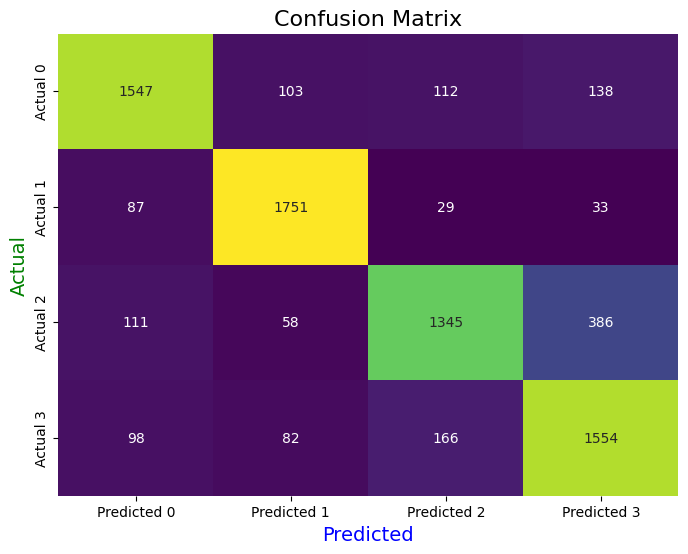

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Create a DataFrame for the confusion matrix with labels for the axes
conf_matrix_df = pd.DataFrame(test_conf_matrix, 
                               index=[f"Actual {i}" for i in range(output_size)], 
                               columns=[f"Predicted {i}" for i in range(output_size)])

# Create a figure and axis
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Plot the confusion matrix as an image
cmap = sns.color_palette("viridis", as_cmap=True)
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap=cmap, cbar=False, ax=ax)

# Set the axis labels
ax.set_xlabel('Predicted', fontsize=14, color='blue')
ax.set_ylabel('Actual', fontsize=14, color='green')

# Set the title
ax.set_title('Confusion Matrix', fontsize=16)

# Show the plot
plt.show()


In [5]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from nltk.tokenize import word_tokenize
import re
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence

# Load the saved word vectors
model_path = '/kaggle/working/svd-word-vectors_15kw3.pt'
checkpoint = torch.load(model_path)
vocab = checkpoint['vocab']
embeddings = checkpoint['embeddings']

# Define a mapping from words to indices
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
UNK_IDX = len(vocab)

# Load the News Classification Dataset
df = pd.read_csv('/kaggle/input/nlpass-2/train.csv')
descriptions = df['Description'].iloc[0:15000]
labels = df['Class Index'].iloc[0:15000]

# Tokenize the text and convert it into sequences of word indices
def preprocess(sentence):
    # Tokenization
    tokens = word_tokenize(sentence.lower())
    # Remove special characters using regex
    tokens = [re.sub(r'[^a-zA-Z0-9 ]', '', word) for word in tokens]
    # Remove empty tokens
    tokens = [word for word in tokens if word]
    indices = [word_to_idx[token] if token in word_to_idx else word_to_idx["<UNK>"] for token in tokens]
    return indices

sentence_indices = []
for desc in descriptions:
    indices = preprocess(desc)
    sentence_indices.append(indices)



# Convert numpy arrays to tensors
sentence_tensors = [torch.tensor(indices) for indices in sentence_indices]

# Pad the sequences
padded_sequences = pad_sequence(sentence_tensors, batch_first=True, padding_value=0)


# Define a PyTorch Dataset for the News Classification Dataset
class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        one_hot_target = np.zeros(4)
        one_hot_target[self.y[idx]-1] = 1
        #return np.array(self.X[idx]),  one_hot_target
        return self.X[idx], torch.tensor(one_hot_target, dtype=torch.float32)


# Create DataLoader objects for training and validation sets
# Create DataLoader objects for training and validation sets
train_dataset = NewsDataset(padded_sequences, labels)

train_loader = DataLoader(train_dataset, batch_size=300, shuffle=True)

# Define an RNN model for classification
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embeddings, dtype=torch.float32))
        self.rnn = nn.LSTM(input_size, hidden_size,num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        logits = self.fc(output[:, -1, :])
        return logits

# Initialize the RNN classifier
input_size = embeddings.shape[1]
hidden_size = 400
output_size = 4  # Number of classes
rnn_classifier = RNNClassifier(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_classifier.parameters(), lr=0.001)


# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    rnn_classifier.train()
    for tokens, labels in train_loader:
        optimizer.zero_grad()
        # Convert tokens to long tensor
        tokens = tokens.long()
        # Forward pass
        logits = rnn_classifier(tokens)
        # Calculate loss
        loss = criterion(logits, labels)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()

    # Print the loss every epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Save the trained model
torch.save(rnn_classifier.state_dict(), 'rnn_classifier_15K_w3.pt')





Epoch 1/5, Loss: 0.6809596419334412
Epoch 2/5, Loss: 0.42304062843322754
Epoch 3/5, Loss: 0.4013839066028595
Epoch 4/5, Loss: 0.42187297344207764
Epoch 5/5, Loss: 0.3241225481033325


In [10]:
# Load the test dataset
test_df =pd.read_csv('/kaggle/input/nlpass-2/test.csv')
test_descriptions = test_df['Description']
test_labels = test_df['Class Index']

# Tokenize and preprocess the test descriptions
test_sentence_indices = []
for desc in test_descriptions:
    indices = preprocess(desc)
    test_sentence_indices.append(indices)
test_sentence_tensors = [torch.tensor(indices) for indices in test_sentence_indices]
padded_test_sequences = pad_sequence(test_sentence_tensors, batch_first=True, padding_value=0)

# Create a DataLoader for the test dataset
test_dataset = NewsDataset(padded_test_sequences, test_labels)
test_loader = DataLoader(test_dataset, batch_size=300, shuffle=False)
# Evaluate the model on the test dataset
rnn_classifier.eval()
correct = 0
total = 0
with torch.no_grad():
    for tokens, labels in test_loader:
        tokens = tokens.long()
        logits = rnn_classifier(tokens)
        #print(logits.shape)
        #print(labels.shape)
        _, predicted = torch.max(logits, 1)
        #print(predicted.shape)
        total += labels.size(0)
        correct += (predicted == labels.argmax(dim=1)).sum().item()

# Calculate the accuracy
accuracy = correct / total
print(f"Test Accuracy: {accuracy}")


Test Accuracy: 0.8153947368421053
